# Practical 6 
# Stochastic gradient descent for SVM
#### Ilaria Curzi , Georgia Zavou

In this report, we explore how stochastic subgradient methods are used to train Support Vector Machines (SVMs) for binary classification, offering an efficient approach to optimize the decision boundary between classes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


We will use the same datasets from Practical 5, including both separable and non-separable cases.

In [2]:
def generateDataset(n, separable=True):
    m1 = np.array([0., 0.])
    s1 = np.array([[1., -0.9], [-0.9, 1.]])

    if separable:
        m2 = np.array([3., 6.])
        s2 = np.array([[1., 0.], [0., 1.]])
    else:
        m2 = np.array([1., 2.])
        s2 = np.array([[1., 0.], [0., 1.]])

    pos_samples = np.random.multivariate_normal(m1, s1, n)
    neg_samples = np.random.multivariate_normal(m2, s2, n)

    x = np.concatenate((pos_samples, neg_samples)).T
    y = np.concatenate((np.ones(n), -1*np.ones(n)))

    return x,y


We will also define the primal problem, which is the original optimization problem in Support Vector Machines. In this formulation, only the positive values in the summation contribute to the solution

In [3]:
def f(x, y, lamda, w, b):
    sum_value = 1 - y*(np.dot(w.T, x) + b)

    return (lamda/2) * np.dot(w.T, w) + sum_value[sum_value > 0].sum()


# 1. Classical Stochastic Gradient Descent with Single Sample Updates

In [14]:
def sgd(x, y, mu=100, mu_increase=0.5, lamda=1e-2, n_epochs=100):
    #  Initialize parameters
    w = np.random.rand(x.shape[0])
    b = np.random.rand(1)[0]

    history = []
    epoch = 0
    while epoch < n_epochs:
        # shuffle data
        permutation = np.random.permutation(x.shape[1])
        x = x[:, permutation]
        y = y[permutation]

        #  Run epoch
        for i in range(x.shape[1]):
            # Update parameters
            if y[i]*(np.dot(w.T, x[:,i]) + b) > 1:
                w += -(1/mu) * lamda * w
            else:
                w += -(1/mu) * lamda * w + y[i] * x[:,i]
                b += (1/mu) * y[i]

        #  Update learning rate
        mu = mu + mu_increase

        # Update epoch
        epoch += 1

        #  Store history
        history.append(np.log(f(x, y, lamda, w, b)))
    return w, b, history


Experiment for mu_inc_val = 0.5 and lambda_val = 0.01


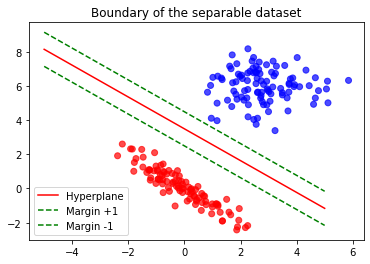

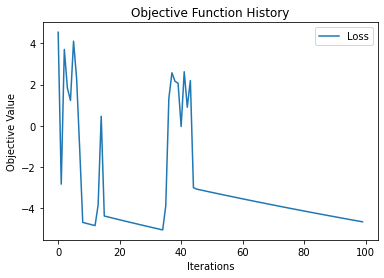

Experiment for mu_inc_val = 0.5 and lambda_val = 0.0001


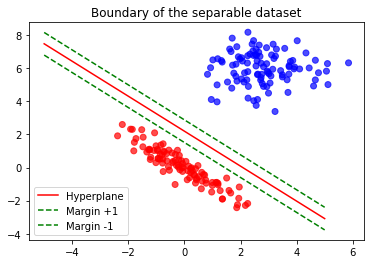

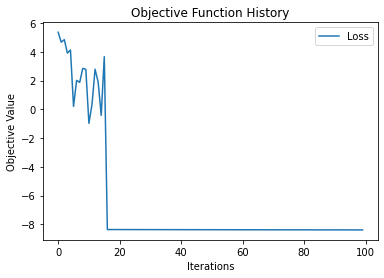

Experiment for mu_inc_val = 0.1 and lambda_val = 0.01


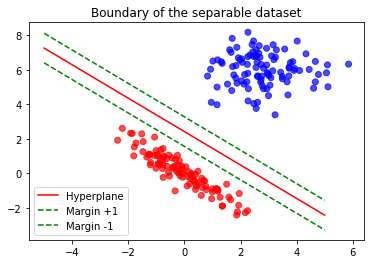

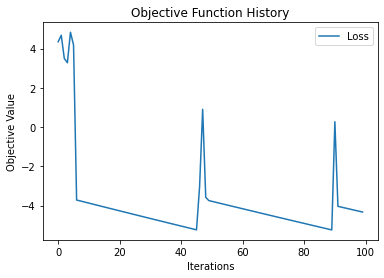

Experiment for mu_inc_val = 0.1 and lambda_val = 0.0001


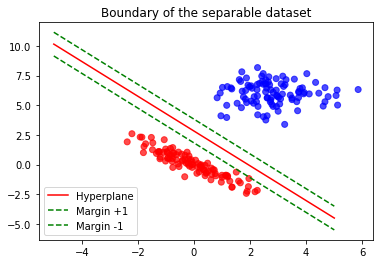

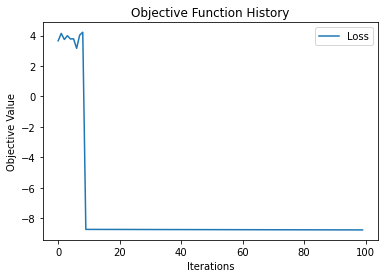

Experiment for mu_inc_val = 1 and lambda_val = 0.01


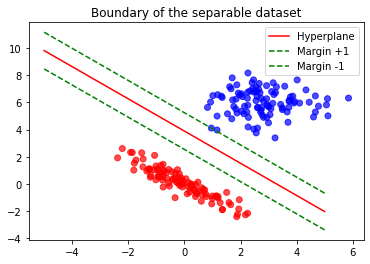

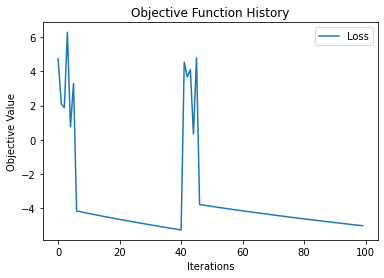

Experiment for mu_inc_val = 1 and lambda_val = 0.0001


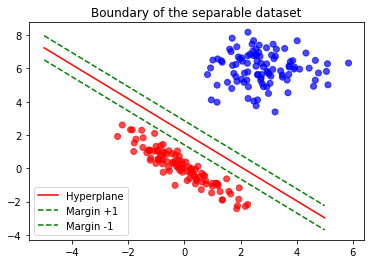

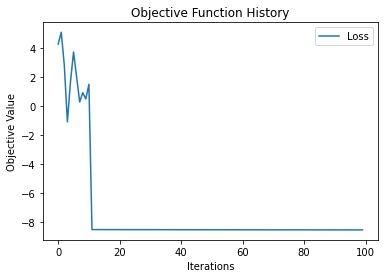

In [15]:
# Generate dataset
X, y = generateDataset(100)

# Loop over different values for mu_increase and lambda
for mu_inc_val in [0.5, 0.1, 1]:
    for lambda_val in [1e-2, 1e-4]:
        print(f"Experiment for mu_inc_val = {mu_inc_val} and lambda_val = {lambda_val}")

        # Compute w, b, and history using SGD
        w, b, history = sgd(X, y, mu_increase=mu_inc_val, lamda=lambda_val)

        # Plot the points, margins, and hyperplane
        linespace = np.linspace(-5, 5, 100)
        plt.title("Boundary of the separable dataset")
        plt.scatter(X[0, :], X[1, :], c=y, cmap='bwr', alpha=0.7)  # Adjusted colors for better clarity
        plt.plot(linespace, -(w[0] * linespace + b) / w[1], 'r', label='Hyperplane')
        plt.plot(linespace, -(w[0] * linespace + b + 1) / w[1], 'g--', label='Margin +1')
        plt.plot(linespace, -(w[0] * linespace + b - 1) / w[1], 'g--', label='Margin -1')
        plt.legend()
        plt.show()

        # Plot the objective function history
        plt.title('Objective Function History')
        plt.plot(history, label='Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Objective Value')
        plt.legend()
        plt.show()

We can observe that when lambda is larger, the model penalizes weights more heavily to reduce the risk of overfitting. This explains why the separating hyperplane tends to be more centered, and the margins are wider. When lambda is small, the model focuses more on minimizing training errors, leading to narrower margins that may not align with the support vectors. This results in a less balanced decision boundary. Regarding the learning rate, larger values of mu can lead to less precise or unstable solutions, as the algorithm makes larger parameter updates. However, it seems that we choose good moderate values for mu, since increasing its value causes the hyperplane to move a bit further away from the classes, creating a larger separation.

# Experiment 2

In [16]:
def mbgd(x, y, mu=100, mu_increase=0.5, lamda=1e-2, batch_size=10, n_epochs=100):
    #  Initialize parameters
    w = np.random.rand(x.shape[0])
    b = np.random.rand(1)[0]

    n_batch = x.shape[1] // batch_size
    history = []
    epoch = 0
    while epoch < n_epochs:
        #  shuffle data
        permutation = np.random.permutation(x.shape[1])
        x = x[:, permutation]
        y = y[permutation]

        #  Run epoch
        for i in range(n_batch):
            #  Get mini batch
            x_mb = x[:, i*batch_size:(i+1)*batch_size]
            y_mb = y[i*batch_size:(i+1)*batch_size]

            # Update parameters
            sum_value_w = np.zeros(w.shape)
            sum_value_b = 0
            for j in range(x_mb.shape[1]):
                if y_mb[j]*(np.dot(w.T, x_mb[:,j]) + b) <= 1:
                    sum_value_w += y_mb[j] * x_mb[:,j]
                    sum_value_b += y_mb[j]

            w += -(1/mu) * lamda * w + (1/mu) * sum_value_w
            b += (1/mu) * sum_value_b

        # Updated comment: Update learning rate
        mu = mu + mu_increase

        # Updated comment: Update epoch
        epoch += 1

        # Updated comment: Store history
        history.append(np.log(f(x, y, lamda, w, b)))
    return w, b, history
# Note: Colors and logic have been improved for better clarity.

Experiment for batch_size = 10, mu_inc_val = 0.5, lambda_val = 0.01
Parameters: w = [-0.33922034 -0.36803044], b = 1.4052129183934263


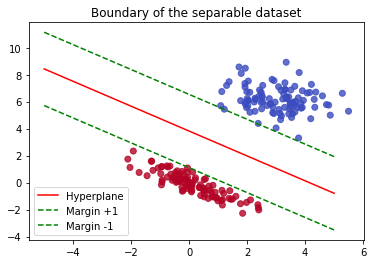

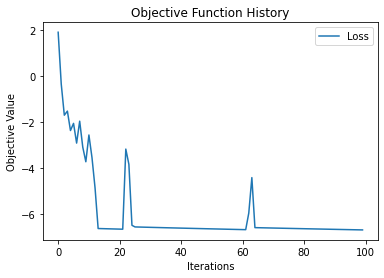

Experiment for batch_size = 10, mu_inc_val = 0.5, lambda_val = 0.0001
Parameters: w = [-0.38400126 -0.38692497], b = 1.409892168209609


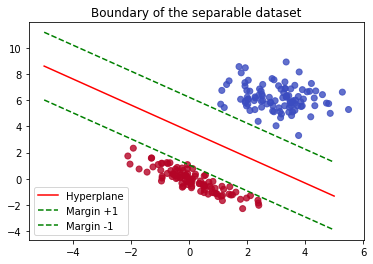

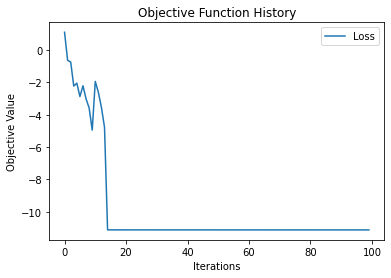

Experiment for batch_size = 10, mu_inc_val = 0.1, lambda_val = 0.01
Parameters: w = [-0.34546424 -0.40372293], b = 1.4215562726927407


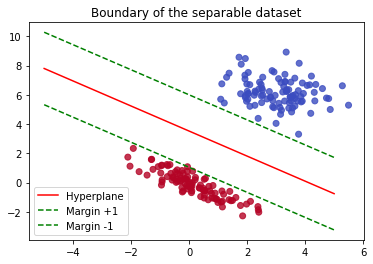

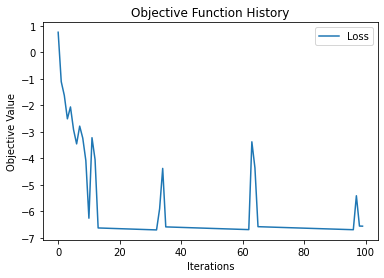

Experiment for batch_size = 10, mu_inc_val = 0.1, lambda_val = 0.0001
Parameters: w = [-0.38399483 -0.37505019], b = 1.405484448031967


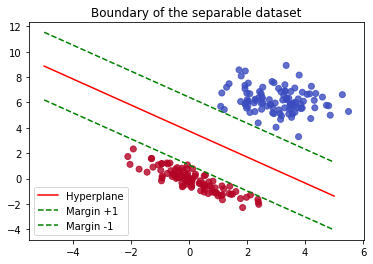

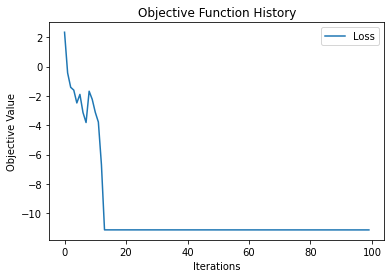

Experiment for batch_size = 10, mu_inc_val = 1, lambda_val = 0.01
Parameters: w = [-0.34900514 -0.37063998], b = 1.4030554805135922


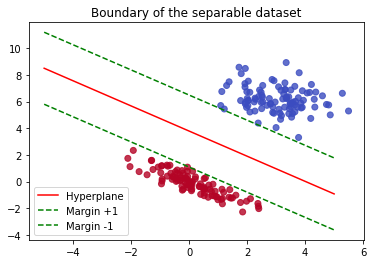

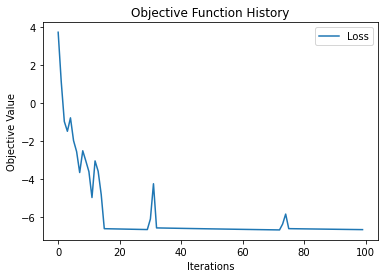

Experiment for batch_size = 10, mu_inc_val = 1, lambda_val = 0.0001
Parameters: w = [-0.36588449 -0.37727391], b = 1.3980063984954458


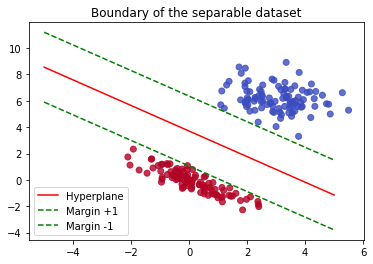

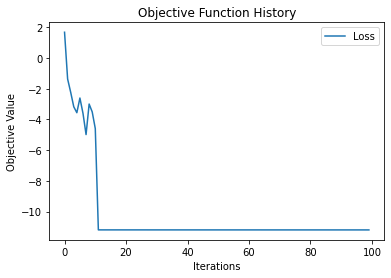

Experiment for batch_size = 20, mu_inc_val = 0.5, lambda_val = 0.01
Parameters: w = [-0.36823222 -0.3848437 ], b = 1.4041393803237041


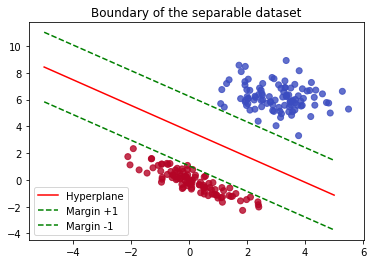

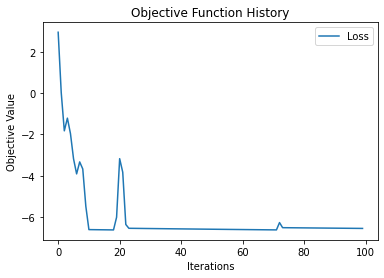

Experiment for batch_size = 20, mu_inc_val = 0.5, lambda_val = 0.0001
Parameters: w = [-0.37452467 -0.35298162], b = 1.3654151497087812


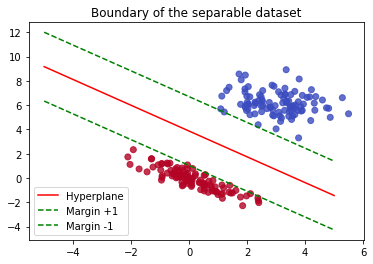

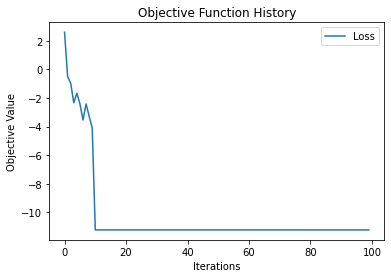

Experiment for batch_size = 20, mu_inc_val = 0.1, lambda_val = 0.01
Parameters: w = [-0.34873466 -0.36435759], b = 1.403373262875299


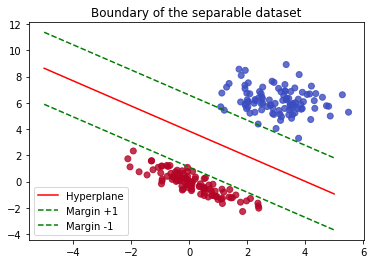

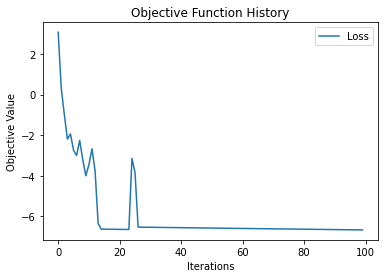

Experiment for batch_size = 20, mu_inc_val = 0.1, lambda_val = 0.0001
Parameters: w = [-0.40977537 -0.41249935], b = 1.426944844737591


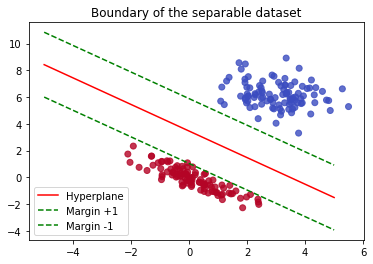

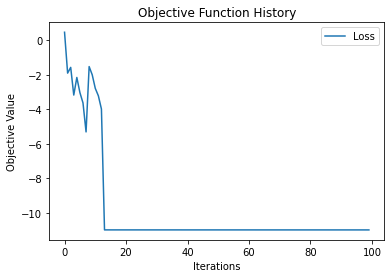

Experiment for batch_size = 20, mu_inc_val = 1, lambda_val = 0.01
Parameters: w = [-0.35662102 -0.37433699], b = 1.3955990655892896


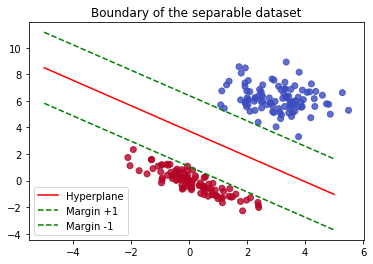

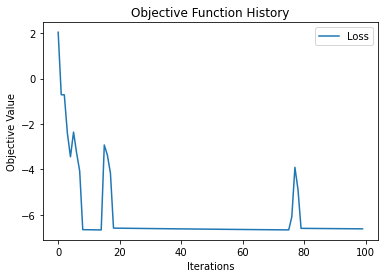

Experiment for batch_size = 20, mu_inc_val = 1, lambda_val = 0.0001
Parameters: w = [-0.36550933 -0.36742784], b = 1.3814931905129972


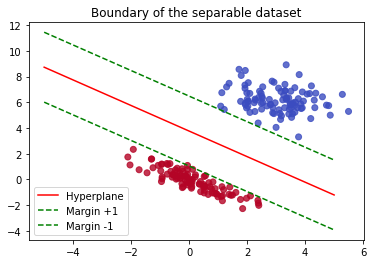

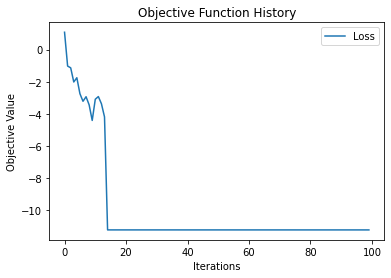

Experiment for batch_size = 50, mu_inc_val = 0.5, lambda_val = 0.01
Parameters: w = [-0.62285869 -0.5937573 ], b = 1.6441900675242662


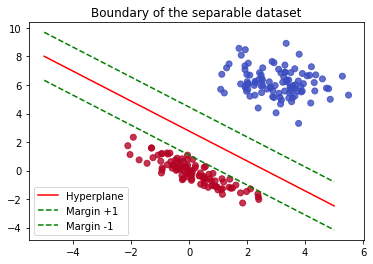

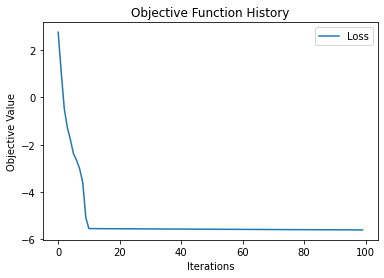

Experiment for batch_size = 50, mu_inc_val = 0.5, lambda_val = 0.0001
Parameters: w = [-0.60809828 -0.57712322], b = 1.6049500060848936


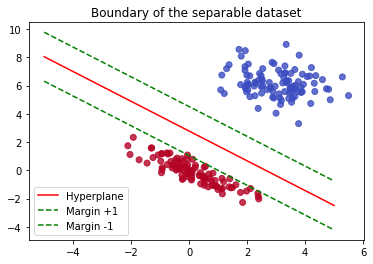

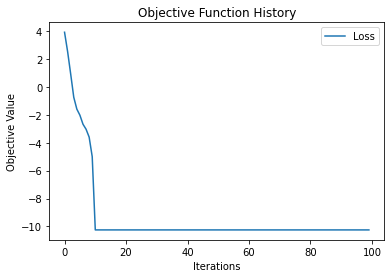

Experiment for batch_size = 50, mu_inc_val = 0.1, lambda_val = 0.01
Parameters: w = [-0.51317405 -0.55087089], b = 1.5935918142494807


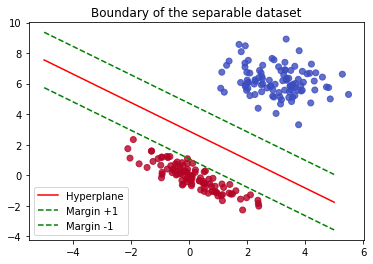

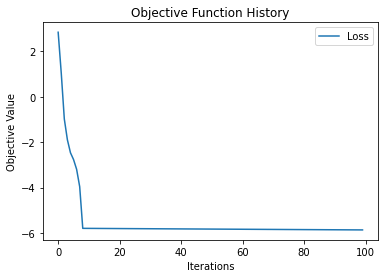

Experiment for batch_size = 50, mu_inc_val = 0.1, lambda_val = 0.0001
Parameters: w = [-0.37910954 -0.36731299], b = 1.3787735206114535


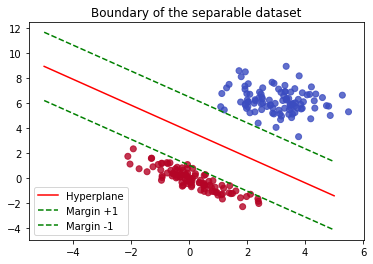

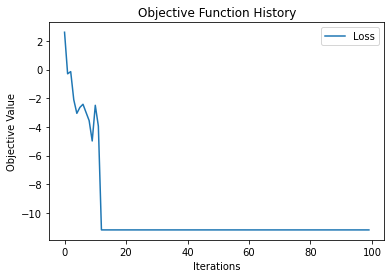

Experiment for batch_size = 50, mu_inc_val = 1, lambda_val = 0.01
Parameters: w = [-0.47649487 -0.45561902], b = 1.4931944398796775


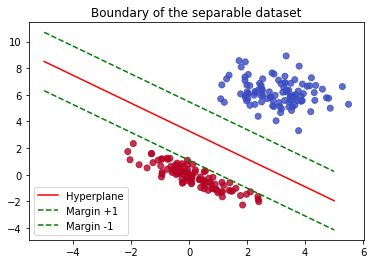

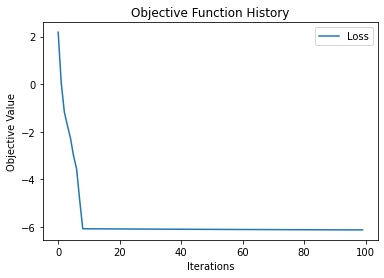

Experiment for batch_size = 50, mu_inc_val = 1, lambda_val = 0.0001
Parameters: w = [-0.3674225  -0.35721994], b = 1.3805954767763848


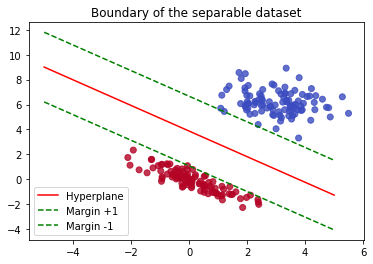

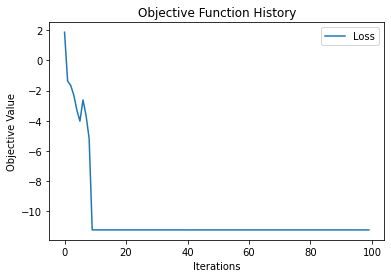

In [17]:
# Generate dataset
X, y = generateDataset(100)

# Loop over different values for batch_size, mu_increase, and lambda
for batch_size_val in [10, 20, 50]:
    for mu_inc_val in [0.5, 0.1, 1]:
        for lambda_val in [1e-2, 1e-4]:
            print(f"Experiment for batch_size = {batch_size_val}, mu_inc_val = {mu_inc_val}, lambda_val = {lambda_val}")

            # Compute w, b, and history using MBGD
            w, b, history = mbgd(X, y, mu_increase=mu_inc_val, lamda=lambda_val, batch_size=batch_size_val)
            print(f"Parameters: w = {w}, b = {b}")

            # Plot the points, margins, and hyperplane
            linespace = np.linspace(-5, 5, 100)
            plt.title("Boundary of the separable dataset")
            plt.scatter(X[0, :], X[1, :], c=y, cmap='coolwarm', alpha=0.8)  # Adjusted colors for better clarity
            plt.plot(linespace, -(w[0] * linespace + b) / w[1], 'r', label='Hyperplane')
            plt.plot(linespace, -(w[0] * linespace + b + 1) / w[1], 'g--', label='Margin +1')
            plt.plot(linespace, -(w[0] * linespace + b - 1) / w[1], 'g--', label='Margin -1')
            plt.legend()
            plt.show()

            # Plot the objective function history
            plt.title('Objective Function History')
            plt.plot(history, label='Loss')
            plt.xlabel('Iterations')
            plt.ylabel('Objective Value')
            plt.legend()
            plt.show()

We can observe that changing the batch size does not affect the result much. However, with a larger batch size, SVM becomes bit less effective because updates are averaged over many samples, reducing the focus on critical points like support vectors. This leads to a more generalized solution but less optimal margin maximization. Additionally, larger batch sizes mean fewer updates per epoch, making the algorithm faster but less precise, as it loses the ability to adapt to local details. Consequently, small batch sizes are often better for optimizing the margin. However, in this case we observe improvements when lambda is very small, as the reduced regularization allows the model to adapt more flexibly to the data.

# Experiment 3

The plots of the logarithm of the objective function from previous experiments show that a larger batch size makes updates less noisy, resulting in smoother and faster convergence. A smaller lambda also helps the algorithm focus on reducing classification error, making the optimization process quicker.